## Домашнее здание №3 / New Product Forecasting

### Фамилия Имя / Группа

----
План выполнения домашнего задания:

1. Подготовка данных
2. Предсказание без категориальных признаков
3. Предсказание с категориальными признаками
4.  Другие модели и генерация дополнительных признаков
5. Отправка результатов в контест на Kaggle

In [2]:
import pandas as pd
import numpy as np
from random import shuffle
from sklearn import tree
from copy import deepcopy
from sklearn.ensemble import BaggingRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import cross_validation
from sklearn.dummy import DummyRegressor
from scipy.optimize import minimize_scalar
from sklearn import preprocessing
import math
import xgboost as xgb
%matplotlib inline

ImportError: No module named xgboost

## Подготовка данных (1 балл)
 * Изучить признаки
 * Выделить категориальные признаки, которые можно использовать для обучения
 * Выделить датасет только с числовыми признаками
 * Выделить полезные числовые признаки

In [ ]:
# data = pd.read_csv('blogData_train.csv', header=None)
data = pd.read_csv('./data/train.csv', sep=';', index_col='ID')
data.shape

### Категориальные признаки
 * Какие категориальные признаки следует использовать в первую очередь? 
 * Есть ли категориальные признаки, которые в принципе не понятно, как использовать?

Наиболее важными кажутся STORE_BRAND_ABC, STORE_CITY, STORE_CLUSTER, STORE_RES_ABC, STORE_RES_SPECTR. Непонятно, как использовать категориальные признаки с большим числом уникальных значений

In [ ]:
# Определяем категориальные признаки
# По понятным причинам 'LOCATION_ID', 'MODEL_ID' считаются числовыми признаками - их добавляем руками отдельно
Categorical_columns = data.columns[([isinstance(z, str) for z in data.ix[0]])].append([['LOCATION_ID', 'MODEL_ID']])
Categorical_columns

In [177]:
# Количество уникальных значений в категориальных признаках
dist_val = pd.DataFrame({'NoUniqueValues': [data[z].nunique() for z in Categorical_columns]}, index = Categorical_columns)

print('Количество уникальных категориальных значений: '+ str(dist_val.sum().values))
print('Удаляем признаки с номерами: \n'+ str(dist_val.ix[dist_val['NoUniqueValues']>34].sort_values(by='NoUniqueValues', ascending=False)))

Количество уникальных категориальных значений: [1654]
Удаляем признаки с номерами: 
                 NoUniqueValues
MODEL_NAME                  447
MODEL_ID                    447
LOCATION_ID                 362
STORE_OPEN_DTTM             246
STORE_CITY                   36


In [178]:
bad_cat_columns = dist_val.ix[dist_val['NoUniqueValues']>34].axes[0]

In [179]:
data = data.drop(bad_cat_columns, axis=1)

In [180]:
Categorical_columns_use = Categorical_columns.drop(bad_cat_columns)

### Числовые признаки
* Какие числовые признаки следует использовать в первую очередь? 
* Есть ли числовые признаки, которые в принципе не понятно, как использовать?
* Как заполнять NaN?

Важными кажутся MODEL_COST_AVG, MODEL_MEAN_SALES, STORE_TYPE_X. NaN заполнять, например, средним

In [182]:
# Выделяем числовой датасет: В данном случае удаляем все + MODEL_ID и LOCATION_ID
num_data = data.drop(Categorical_columns_use, axis = 1)
num_data.columns

Index([u'DEMAND', u'MODEL_COST_AVG', u'MODEL_COUNT_SALES_DAYS', u'MODEL_DIAG',
       u'MODEL_HEIGHT', u'MODEL_MEAN_SALES', u'MODEL_WIDTH',
       u'STORE_ASSORTMENT', u'STORE_BRAND_SPECTR', u'STORE_DIAG_SPECTR',
       u'STORE_RES_SPECTR', u'STORE_TYPE_A', u'STORE_TYPE_B', u'STORE_TYPE_C',
       u'STORE_TYPE_SPECTR'],
      dtype='object')

In [183]:
# Количество NaN в числовых признаках
print('Количество NaN:')
nan_val = num_data.isnull().sum().T
nan_val
# print('Удаляем признаки с номерами: \n'+ str(nan_val.sort_values(by='NoUniqueValues', ascending=False)))

Количество NaN:


DEMAND                        0
MODEL_COST_AVG                0
MODEL_COUNT_SALES_DAYS    18917
MODEL_DIAG                  212
MODEL_HEIGHT                212
MODEL_MEAN_SALES          18917
MODEL_WIDTH                 212
STORE_ASSORTMENT            235
STORE_BRAND_SPECTR          235
STORE_DIAG_SPECTR           442
STORE_RES_SPECTR            446
STORE_TYPE_A                  0
STORE_TYPE_B                  0
STORE_TYPE_C                  0
STORE_TYPE_SPECTR             0
dtype: int64

##### Преобразовываем числовые признаки (удаляем/добавляем/заменяем nan)

In [ ]:
# Здесь добавьте код по преобразованию числовых признаков

# пример
num_data[???][num_data[???]<числовой порог]=значение

In [184]:
# Здесь добавьте код по заполнению NaN
#num_data = num_data[список фич].fillna(значение)
num_data = num_data.fillna(num_data.mean())

In [ ]:
# Здесь добавьте код по удалению числовых признаков
num_data.drop([список фич], axis = 1, inplace=True)
num_data.columns

## Предсказание без категориальных признаков (1 балл)
### Вспомогательные функции

In [3]:
def smape_loss_func(x, y):
    SymAPE = [ 2*np.abs(x-y)/(np.abs(x)+np.abs(y))] 
    return np.mean(SymAPE)

def get_numerated_data(df, categorical_columns):
    simple_df = deepcopy(df)
    for column in categorical_columns:
        simple_df[column] = pd.Categorical.from_array(simple_df[column]).labels
    
    return simple_df

def get_binarized_data(df, categorical_columns):
    binary_df = deepcopy(df)
    for column in categorical_columns:
        binary_df = pd.concat([binary_df, pd.get_dummies(binary_df[column], prefix=column, prefix_sep=': ')], axis=1)
        del binary_df[column]
    
    return binary_df

def split_to_numpy(df, y_column_name):
    #print df
    #print y_column_name
    data_x = df.drop(y_column_name, axis=1).values.astype(np.float32)
    data_y = df[y_column_name].values.astype(np.float32)
    column_names = df.drop(y_column_name, axis=1).columns
    
    return data_x, data_y, column_names

def split_train_test(df, test_size=0.5, random_state=42, y_column_name='y'):
    X = np.asarray(df.drop(y_column_name, axis=1))
    y = np.asarray(df[y_column_name]).ravel()
    trainX, testX, trainY, testY = cross_validation.train_test_split(X, y, test_size=test_size, random_state=42)
    return trainX, testX, trainY, testY

### Необходимые функции

In [4]:
def show_plot(n_est, res, title="", ylabel="acc"):
    fig, ax = plt.subplots()
    ax.plot(n_est, [res[x][1] for x in n_est], 'ro')
#     ax.set_xlim((np.min(n_est) - 10, np.max(n_est) + 10))
#     plt.xlabel("n_estimators")
#     plt.ylabel(ylabel)
#     plt.title("Test result")
#     plt.show()
    
#     fig, ax = plt.subplots()
    ax.plot(n_est, [res[x][0] for x in n_est], 'bo')
    ax.set_xlim((np.min(n_est) - 10, np.max(n_est) + 10))
    plt.xlabel("n_estimators")
    plt.ylabel("acc")
    plt.title(title)
    plt.show()

def get_results_dummy_reg(acc=smape_loss_func, verbose=True, strg ='mean', const=None):
    results = dict()
    reg = DummyRegressor(strategy=strg, constant=const)
    reg.fit(trainX, trainY)
    predict = reg.predict(testX)
    results[1] = (acc(trainY, reg.predict(trainX)), acc(testY, predict))
    if verbose:
        print("Accuracy: " + str(results[1][1]))
    return results

def get_results_baggind_rsm(n_est, max_samples, max_features, acc=smape_loss_func, verbose=True):
    results = dict()
    for i in n_est:
        reg = BaggingRegressor(n_estimators=i,
                          max_samples=max_samples, max_features=max_features, random_state=1234, n_jobs=-1, verbose=0)
        reg.fit(trainX, trainY)
#         results[i] = (mse(reg.predict(trainX), trainY), mse(reg.predict(testX), testY))
        predict = reg.predict(testX)
        results[i] = (acc(trainY, reg.predict(trainX)), acc(testY, predict))
        if verbose:
            print("Count of estimators: " + str(i) + ", accuracy: " + str(results[i][1]))
    return results

def get_results_rf(n_est, oob=False, verbose=True, acc=smape_loss_func):
    results = dict()
    for i in n_est:
        reg = RandomForestRegressor(n_estimators=i, n_jobs=-1, random_state=1234, verbose=0,
                                    oob_score=oob, max_features='sqrt')
        reg.fit(trainX, trainY)
        predict = reg.predict(testX)
        if oob:
            results[i] = (reg.oob_score_, acc(predict, testY))
        else:
            results[i] = (acc(trainY, reg.predict(trainX)), acc(testY,predict))
        if verbose:
            print("Count of estimators: " + str(i) + ", accuracy: " + str(results[i][1]))
    return results

def get_results_erte(n_est, verbose=True,acc=smape_loss_func):
    results = dict()
    for i in n_est:
        reg = ExtraTreesRegressor(n_estimators=i, n_jobs=-1, random_state=12, verbose=0)
        reg.fit(trainX, trainY)
        predict = reg.predict(testX)
        results[i] = (acc(trainY,reg.predict(trainX)), acc(predict, testY))
        if verbose:
            print("Count of estimators: " + str(i) + ", accuracy: " + str(results[i][1]))
    return results

def get_results_gbdt(n_est, verbose=True, init=None, acc=smape_loss_func, min_max_filter=True, max_val=1, min_val=0.001):
    results = dict()
    for i in n_est:
        if init is not None:
            reg = GradientBoostingRegressor(n_estimators=i, random_state=1234, verbose=0, init=init)
        else:
            reg = GradientBoostingRegressor(n_estimators=i, random_state=1234, verbose=0)
        reg.fit(trainX, trainY)
        predict = reg.predict(testX)
        if min_max_filter:
            predict = np.minimum(np.maximum(predict, min_val),max_val)
        results[i] = (acc(trainY, reg.predict(trainX)), acc(testY, predict))
        if verbose:
            print("Count of estimators: " + str(i) + ", accuracy: " + str(results[i][1]))    
    return results

def get_optimal(results):
    results = sorted(results, key=lambda x: x[1])

### Делим выборку на обучение и контроль

In [187]:
trainX, testX, trainY, testY = split_train_test(df = num_data, test_size=0.1,  y_column_name='DEMAND')

### DummyRegressor
* Самый простой классификатор на числовых признаках используется как база для сравнения

In [188]:
%time results = get_results_dummy_reg()
%time results = get_results_dummy_reg(strg='constant', const=0.001)

Accuracy: 1.24306344718
Wall time: 58 ms
Accuracy: 1.81014628129
Wall time: 1e+03 µs


### Bagging and RSM
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

** Каким стоит брать размер bootstrap выборки и RSM выборки ** 
Например: 
**Bagging:** 0.5 от размера тестовой выборки.

**RSM:** 0.5 от размера тестовой выборки.

Count of estimators: 10, accuracy: 1.21757052076
Count of estimators: 20, accuracy: 1.21876096028
Count of estimators: 30, accuracy: 1.21833525178
Count of estimators: 40, accuracy: 1.21981837786
Count of estimators: 50, accuracy: 1.2209139137
Count of estimators: 60, accuracy: 1.22577191963
Count of estimators: 70, accuracy: 1.22647313164
Count of estimators: 80, accuracy: 1.22691586121
Count of estimators: 90, accuracy: 1.22402245546
Count of estimators: 100, accuracy: 1.22293614598
Count of estimators: 110, accuracy: 1.22227419438
Count of estimators: 120, accuracy: 1.22156605596
Count of estimators: 130, accuracy: 1.22163503586
Count of estimators: 140, accuracy: 1.22302186113
Wall time: 1min 59s


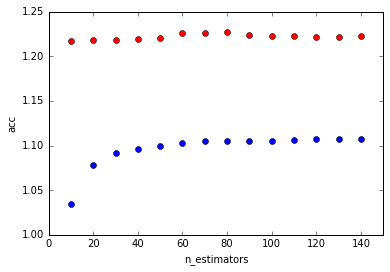

In [189]:
n_est = range(10, 150, 10)
%time results = get_results_baggind_rsm(n_est, 0.5, 0.5, verbose=True)
show_plot(n_est, results)

### Random Forest
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 1.16751739424
Count of estimators: 20, accuracy: 1.19995117818
Count of estimators: 30, accuracy: 1.20933973869
Count of estimators: 40, accuracy: 1.21302274719
Count of estimators: 50, accuracy: 1.2131378178
Count of estimators: 60, accuracy: 1.21476988601
Count of estimators: 70, accuracy: 1.21456431028
Count of estimators: 80, accuracy: 1.21605624606
Count of estimators: 90, accuracy: 1.21716994385
Count of estimators: 100, accuracy: 1.21612894808
Count of estimators: 110, accuracy: 1.21703204479
Count of estimators: 120, accuracy: 1.21764472669
Count of estimators: 130, accuracy: 1.21818265976
Count of estimators: 140, accuracy: 1.21923241933
Wall time: 43.7 s


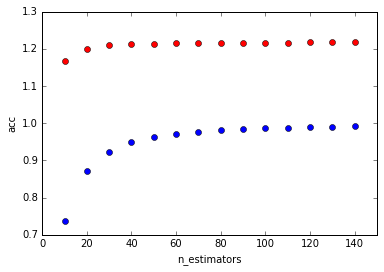

In [190]:
n_est = range(10, 150, 10)
%time results = get_results_rf(n_est)
show_plot(n_est, results)

### Extremely Randomized Trees Ensemble
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 1.13312337988
Count of estimators: 20, accuracy: 1.18839127641
Count of estimators: 30, accuracy: 1.20770876077
Count of estimators: 40, accuracy: 1.21652063412
Count of estimators: 50, accuracy: 1.22206755786
Count of estimators: 60, accuracy: 1.22331837238
Count of estimators: 70, accuracy: 1.22364573341
Count of estimators: 80, accuracy: 1.22477886538
Count of estimators: 90, accuracy: 1.22625027117
Count of estimators: 100, accuracy: 1.2257802935
Count of estimators: 110, accuracy: 1.22610528937
Count of estimators: 120, accuracy: 1.22672814643
Count of estimators: 130, accuracy: 1.22662682854
Count of estimators: 140, accuracy: 1.22674093444
Wall time: 1min 9s


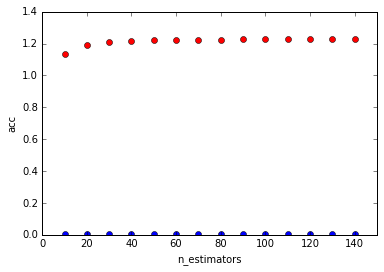

In [191]:
n_est = range(10, 150, 10)
%time results = get_results_erte(n_est)
show_plot(n_est, results)

## Gradient Boosted Decision Trees
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 1.22651418244
Count of estimators: 20, accuracy: 1.22200229537
Count of estimators: 30, accuracy: 1.22088902896
Count of estimators: 40, accuracy: 1.22361675402
Count of estimators: 50, accuracy: 1.22283973954
Count of estimators: 60, accuracy: 1.22108057118
Count of estimators: 70, accuracy: 1.22005304555
Count of estimators: 80, accuracy: 1.2191204379
Count of estimators: 90, accuracy: 1.2179164763
Count of estimators: 100, accuracy: 1.21792287334
Count of estimators: 110, accuracy: 1.21733304195
Count of estimators: 120, accuracy: 1.21798575453
Count of estimators: 130, accuracy: 1.21756830611
Count of estimators: 140, accuracy: 1.21816097194
Wall time: 36.1 s


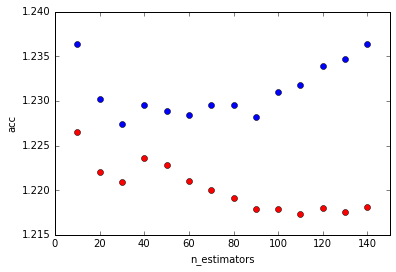

In [192]:
n_est = range(10, 150, 10)
%time results = get_results_gbdt(n_est)
show_plot(n_est, results)

### Вывод
Переобучаются ExtraDT, остальные методы показывают результаты на одном уровне (в пределах погрешности).

Для RF и Baggin+RSM оптимальные значения кол-ва близко к 20.

Для GBDT оптимальное количество алгоритмов находится в районе 50.

**Вопрос: Дайте интепретацию полученным результатам в вашем случае.**

Bagging и Boosting дают примерно одинаковые результаты: нужно работать как над уменьшением смещения, так и разброса.
Видимо, ...

## Использование категориальных признаков (1 балл)
* Проведите аналогичный экспермент при наличии категориальных признаков

### Обучение и Контроль

In [193]:
# Для обучения используются полезные категориальные признаки
bin_data = get_binarized_data(data, Categorical_columns_use)
print(bin_data.shape)

(40000, 131)


##### Исключаем лишние произнаки, заменяем NaN

In [141]:
# Удаляем лишние категоримальные признаки
bin_data.drop(..., axis = 1, inplace=True)

In [ ]:
# Удаляем лишние числвые признаки признаки
bin_data = bin_data.drop([лишние числовые признаки], axis = 1, inplace = True)

In [196]:
# Заменяем NaN
bin_data.fillna(bin_data.mean(), inplace = True)
print

In [197]:
# Делим выборку на обучение и контроль
trainX, testX, trainY, testY = split_train_test(df = bin_data, test_size=0.1,  y_column_name='DEMAND')

### Bagging and RSM
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 1.13819751255
Count of estimators: 20, accuracy: 1.17964374409
Count of estimators: 30, accuracy: 1.18970820949
Count of estimators: 40, accuracy: 1.19759738841
Count of estimators: 50, accuracy: 1.20122936999
Count of estimators: 60, accuracy: 1.20343441241
Count of estimators: 70, accuracy: 1.20550762643
Count of estimators: 80, accuracy: 1.20533726314
Count of estimators: 90, accuracy: 1.20585851954
Count of estimators: 100, accuracy: 1.20604173915
Count of estimators: 110, accuracy: 1.20549059966
Count of estimators: 120, accuracy: 1.20415545718
Count of estimators: 130, accuracy: 1.20456459313
Count of estimators: 140, accuracy: 1.20428272751
Wall time: 8min 47s


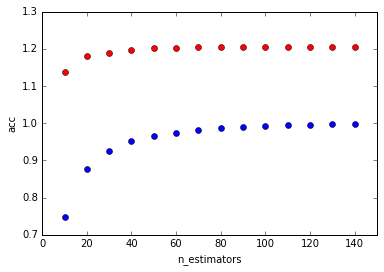

In [198]:
n_est = range(10, 150, 10)
%time results = get_results_baggind_rsm(n_est, 0.9, 0.9, verbose=True)
show_plot(n_est, results)

### Random Forest
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 1.1771776661
Count of estimators: 20, accuracy: 1.19230988727
Count of estimators: 30, accuracy: 1.1956016774
Count of estimators: 40, accuracy: 1.19691405417
Count of estimators: 50, accuracy: 1.19921469784
Count of estimators: 60, accuracy: 1.19952344925
Count of estimators: 70, accuracy: 1.20049376673
Count of estimators: 80, accuracy: 1.20034838047
Count of estimators: 90, accuracy: 1.20262013097
Count of estimators: 100, accuracy: 1.20235039768
Count of estimators: 110, accuracy: 1.20216845039
Count of estimators: 120, accuracy: 1.20101840503
Count of estimators: 130, accuracy: 1.2018602448
Count of estimators: 140, accuracy: 1.2012164304
Wall time: 1min 4s


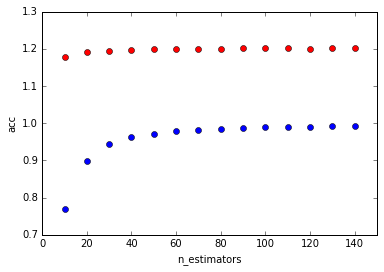

In [199]:
n_est = range(10, 150, 10)
%time results = get_results_rf(n_est)
show_plot(n_est, results)

### Extremely Randomized Trees Ensemble
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 1.07624214441
Count of estimators: 20, accuracy: 1.12933242683
Count of estimators: 30, accuracy: 1.14624048592
Count of estimators: 40, accuracy: 1.16237392198
Count of estimators: 50, accuracy: 1.16966095619
Count of estimators: 60, accuracy: 1.17402560725
Count of estimators: 70, accuracy: 1.17627972975
Count of estimators: 80, accuracy: 1.1772184831
Count of estimators: 90, accuracy: 1.17835857856
Count of estimators: 100, accuracy: 1.17907261785
Count of estimators: 110, accuracy: 1.18159477341
Count of estimators: 120, accuracy: 1.18159585597
Count of estimators: 130, accuracy: 1.18352591886
Count of estimators: 140, accuracy: 1.18398787093
Wall time: 9min 39s


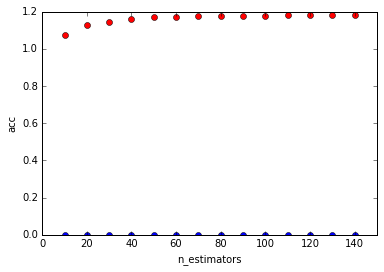

In [200]:
n_est = range(10, 150, 10)
%time results = get_results_erte(n_est)
show_plot(n_est, results)

### Gradient Boosted Decision Trees
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 1.22187940831
Count of estimators: 20, accuracy: 1.21852827663
Count of estimators: 30, accuracy: 1.21459900844
Count of estimators: 40, accuracy: 1.21775273345
Count of estimators: 50, accuracy: 1.21688654485
Count of estimators: 60, accuracy: 1.21712305354
Count of estimators: 70, accuracy: 1.21685712082
Count of estimators: 80, accuracy: 1.21548401458
Count of estimators: 90, accuracy: 1.2158950184
Count of estimators: 100, accuracy: 1.21601854863
Count of estimators: 110, accuracy: 1.21492691858
Count of estimators: 120, accuracy: 1.21436169632
Count of estimators: 130, accuracy: 1.21394356073
Count of estimators: 140, accuracy: 1.2159989781
Wall time: 4min 25s


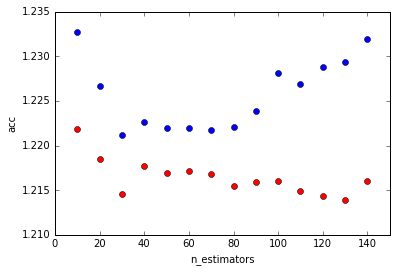

In [201]:
n_est = range(10, 150, 10)
%time results = get_results_gbdt(n_est)
show_plot(n_est, results)

### Вывод

**Вопрос: Дайте интепретацию полученным результатам в вашем случае.**

Использование категориальных признаков не сильно изменило результаты

## Другие модели и генерация дополнительных признаков (2 балла)

* На основании сделанных выводов, предложите другой вариант алгоритма ML, который должен показать лучший результат
* Направляния:
    -- использовать принципиально другое семейство алгоритмов (NN, GB+kNN, LinearRegression, композиция Baggin и GBDT)
    -- исключить бесполезные фичи из обучающей выборки (полезность фич проанализировать с помощью RF);
    -- исключить фичи, в которых есть NaN; сделать восстановление NaN более интеллектуально;
    -- преобразовать катеориальные признаки так, чтобы получились числовые.

### Вывод

In [151]:
def apply_f_to_col_inline(df, col, f):
    df[col] = df[col].apply(f)

In [152]:
def datetime_to_log_age(datetimestr):
    x = 16-int(datetimestr[5:7])
    x = (x+100) if x < 0 else x  # 20 or 21 century
    return np.log(x+1)

def abc_to_210(abc):
    if abc == 'A':
        return 2
    if abc == 'B':
        return 1
    return 0

def model_type_to_bool(mtype):
    if mtype == 'не смартфон':
        return 0
    return 1

def get_mean_demand_for_value(df, column, value):
    interested_in = df[['DEMAND', column]]
    interested_in = interested_in.loc[df[column] == value]
    mean = interested_in.mean()[0]
    return 0 if np.isnan(mean) else mean

def process_bad_categorical_columns(df, columns):
    for column in columns:
        values = set(df[column].values)
        apply_f_to_col_inline(df, column,lambda x :
                              0 if x not in mean_demands[column].keys() else mean_demands[column][x])

In [153]:
def collect_mean_demands():
    data = pd.read_csv('./data/train.csv', sep=';', index_col='ID')
    Redundant_columns = ['MODEL_NAME', 'MODEL_COUNT_SALES_DAYS', 'MODEL_DIAG_TYPE', 'MODEL_HEIGHT', 'MODEL_WIDTH']
    data.drop(Redundant_columns, inplace=True, axis=1)
    ABC_cols = [x for x in data.columns if x.endswith('ABC')]
    for col in ABC_cols:
        apply_f_to_col_inline(data, col, abc_to_210)
    apply_f_to_col_inline(data, 'STORE_OPEN_DTTM', datetime_to_log_age)
    apply_f_to_col_inline(data, 'MODEL_TYPE', model_type_to_bool)
    Categorical_columns = data.columns[([isinstance(z, str) for z in data.ix[0]])].append([['LOCATION_ID', 'MODEL_ID']])
    Numerical_columns = data.columns[([z not in Categorical_columns for z in data.columns])]
    dist_val = pd.DataFrame({'NoUniqueValues': [data[z].nunique() for z in Categorical_columns]}, index = Categorical_columns)
    threshold = 7
    bad_cat_columns = dist_val.ix[dist_val['NoUniqueValues']>threshold].axes[0]
    mean_demands = dict()
    for column in bad_cat_columns:
        values = set(data[column].values)
        mean_demands[column] = dict()
        for value in values:
            mean_demands[column][value] = get_mean_demand_for_value(data, column, value)
    return mean_demands

In [154]:
mean_demands = collect_mean_demands()

In [194]:
def prepare_data(data, scalers=None):
    Redundant_columns = ['MODEL_NAME', 'MODEL_COUNT_SALES_DAYS', 'MODEL_DIAG_TYPE', 'MODEL_HEIGHT', 'MODEL_WIDTH']
    data.drop(Redundant_columns, inplace=True, axis=1)
    
    ABC_cols = [x for x in data.columns if x.endswith('ABC')]
    for col in ABC_cols:
        apply_f_to_col_inline(data, col, abc_to_210)
    
    apply_f_to_col_inline(data, 'STORE_OPEN_DTTM', datetime_to_log_age)
    apply_f_to_col_inline(data, 'MODEL_TYPE', model_type_to_bool)
    
    Categorical_columns = data.columns[([isinstance(z, str) for z in data.ix[0]])].append([['LOCATION_ID', 'MODEL_ID']])
    Numerical_columns = data.columns[([z not in Categorical_columns for z in data.columns])]            
    
    dist_val = pd.DataFrame({'NoUniqueValues': [data[z].nunique() for z in Categorical_columns]},
                            index = Categorical_columns)
    threshold = 7
#     print('Заменяем на mean признаки: \n'+ \
#           str(dist_val.ix[dist_val['NoUniqueValues']>threshold].sort_values(by='NoUniqueValues', ascending=False)))
    bad_cat_columns = dist_val.ix[dist_val['NoUniqueValues']>threshold].axes[0]
    #data.drop(bad_cat_columns, axis=1, inplace=True)
    process_bad_categorical_columns(data, bad_cat_columns)
    
    Categorical_columns = data.columns[([isinstance(z, str) for z in data.ix[0]])]
    data = get_binarized_data(data, Categorical_columns)
    
    # with mean sales and without
    datasets = [data.loc[~np.isnan(data['MODEL_MEAN_SALES'])], #[0] extended
                data.loc[np.isnan(data['MODEL_MEAN_SALES'])].drop(['MODEL_MEAN_SALES'], axis=1)]
    del data
    
    for dataset in datasets:
        dataset.fillna(dataset.mean(), inplace=True)
    
    bool_train = (scalers==None)
    if bool_train:
        scalers = [preprocessing.StandardScaler() for i in range(2)]
        for dataset, scaler in zip(datasets, scalers):
            X_cols = [col for col in dataset.columns if col != 'DEMAND']
            dataset[X_cols] = scaler.fit_transform(dataset[X_cols])
        return datasets, scalers
    else:    
        for dataset, scaler in zip(datasets, scalers):
            dataset[:] = scaler.transform(dataset[:])
        return datasets
        

In [195]:
datasets, scalers = prepare_data(pd.read_csv('./data/train.csv', sep=';', index_col='ID'))

In [196]:
trainX, testX, trainY, testY = split_train_test(df=datasets[0], test_size=0.2, y_column_name='DEMAND')

Count of estimators: 1, accuracy: 0.833997448714
Count of estimators: 3, accuracy: 0.920011514666
Count of estimators: 5, accuracy: 0.984501483823
Count of estimators: 7, accuracy: 1.03561777399
Count of estimators: 9, accuracy: 1.05581568522
Count of estimators: 11, accuracy: 1.06859356393
Count of estimators: 13, accuracy: 1.08161313933
CPU times: user 9.8 s, sys: 112 ms, total: 9.91 s
Wall time: 5.09 s


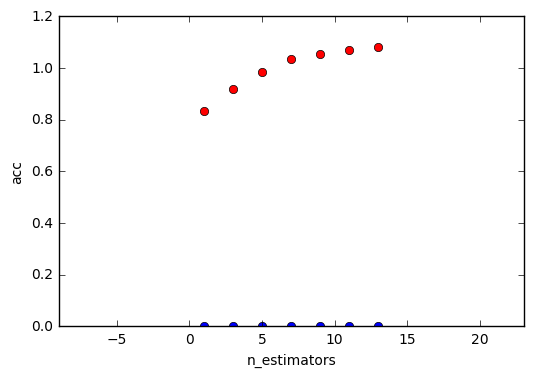

In [197]:
n_est = range(1, 15, 2)
%time results = get_results_erte(n_est)
show_plot(n_est, results)

Count of estimators: 1, accuracy: 0.964606126125
Count of estimators: 2, accuracy: 0.997669348108
Count of estimators: 3, accuracy: 1.04294072579
Count of estimators: 4, accuracy: 1.09402801566
Count of estimators: 5, accuracy: 1.12340913573
Count of estimators: 6, accuracy: 1.14752410795
Count of estimators: 7, accuracy: 1.1600321279
Count of estimators: 8, accuracy: 1.16752907503
Count of estimators: 9, accuracy: 1.17217179207
CPU times: user 3.37 s, sys: 100 ms, total: 3.47 s
Wall time: 3.94 s


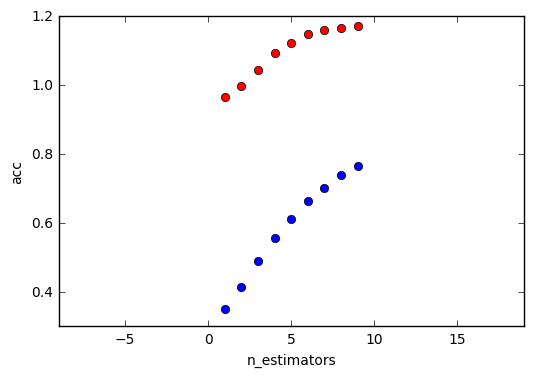

In [198]:
n_est = range(1, 10, 1)
%time results = get_results_rf(n_est)
show_plot(n_est, results)

In [199]:
def get_results(reg, acc=smape_loss_func, min_max_filter=True, max_val=1, min_val=0.0001):
    reg.fit(trainX, trainY)
    predict = reg.predict(testX)
    if min_max_filter:
        predict = np.minimum(np.maximum(predict, min_val),max_val)
    results = (acc(trainY, reg.predict(trainX)), acc(testY, predict))
    print("Loss: " + str(results[1]))    
    return results

In [200]:
regressor = xgb.XGBRegressor(max_depth=13, n_estimators=100, learning_rate=0.1, objective="reg:linear",gamma=0,
                                min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1,
                                colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                                base_score=0.5)
get_results(regressor, min_max_filter=True)

Loss: 1.08833256944


(0.95530641141838812, 1.0883325694383548)

In [201]:
class Wrapper:
    def __init__(self, regs):
        self.regressors_ = regs
        
    def fit(self, datasets):
        trainY_ext = datasets[0]['DEMAND']
        trainX_ext = datasets[0].drop(['DEMAND'], axis=1)
        trainY = datasets[1]['DEMAND']
        trainX = datasets[1].drop(['DEMAND'], axis=1)
        self.regressors_[0].fit(trainX_ext, trainY_ext)
        self.regressors_[1].fit(trainX, trainY)
        
    def predict(self, datasets):
        pred_ext = pd.DataFrame(self.regressors_[0].predict(datasets[0]),
                                index = datasets[0].index, columns=pd.Index(['DEMAND']))
        pred = pd.DataFrame(self.regressors_[1].predict(datasets[1]),
                            index = datasets[1].index, columns=pd.Index(['DEMAND']))
        max_val=1
        min_val=0.0001
        pred_ext = np.minimum(np.maximum(pred_ext, min_val),max_val)
        pred = np.minimum(np.maximum(pred, min_val),max_val)
        return pred_ext, pred

In [202]:
wrp = Wrapper([xgb.XGBRegressor(max_depth=13, n_estimators=100, learning_rate=0.1, objective="reg:linear",gamma=0,
                                min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1,
                                colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                                base_score=0.5) for i in range(2)])

In [203]:
wrp = Wrapper([ExtraTreesRegressor(n_estimators=1, n_jobs=-1, random_state=12, verbose=0) for i in range(2)])

In [204]:
wrp.fit(datasets)

## Отправка результатов в контест на Kaggle (оценивается по результатам в Leaderboard)

In [205]:
test_datasets = prepare_data(pd.read_csv('./data/test.csv', sep=';',decimal= '.', index_col='ID'), scalers)

In [206]:
pred_ext, pred = wrp.predict(test_datasets)

In [207]:
result = pd.concat([pred_ext, pred]).sort_index()

In [208]:
result.to_csv('./data/submission.csv', sep = ',', index = True)

In [209]:
print result

         DEMAND
ID             
0      0.000100
1      0.040822
2      0.032790
3      0.064516
4      0.000100
5      0.000100
6      0.098387
7      0.000100
8      0.101724
9      0.200334
10     0.000100
11     0.473404
12     0.054067
13     0.037740
14     0.032258
15     0.074108
16     0.000100
17     0.000100
18     0.000100
19     0.000100
20     0.000100
21     0.000100
22     0.000100
23     0.762689
24     0.064516
25     0.000100
26     0.037740
27     0.081655
28     0.000100
29     0.000100
...         ...
11266  0.000100
11267  0.000100
11268  0.232768
11269  0.161290
11270  0.000100
11271  0.000100
11272  0.032258
11273  0.000100
11274  0.040822
11275  0.000100
11276  0.000100
11277  0.032258
11278  0.000100
11279  0.000100
11280  0.188791
11281  0.287682
11282  0.095310
11283  0.064516
11284  0.000100
11285  0.096774
11286  0.129032
11287  0.080043
11288  0.000100
11289  0.121655
11290  0.064516
11291  0.032258
11292  0.135645
11293  0.000100
11294  0.000100
11295  0

In [265]:
# Предобработка тестовой выборки (добавляем\удаляем признаки, предобработка NaN и пр.)
test_data = get_binarized_data(test, Categorical_columns[категориальные признаки])

In [266]:
# Все отсутствующие в тестовой выборке столбцы полагаем 0
add_columns = bin_data.columns[1:].difference(test_data.columns)
test_data = pd.merge(test_data, bin_data.ix[test_data.index][add_columns], how='inner', left_index=True, right_index=True)
test_data[add_columns]=0

# Оставляем только столбцы обучающей выборки (целевая переменная в обучающей выборке отсутствует)
test_data = test_data[bin_data.columns[1:]]

test_data = test_data.fillna(-10, inplace=True)

In [ ]:
# Обучающая выборка
trainX, _, trainY, _ = split_train_test(df = bin_data, test_size=0,  y_column_name='DEMAND')

In [294]:
# Обучаем финальный алгоритм
final_regressor = финальный алгоритм
final_regressor.fit(trainX, trainY)

In [271]:
# Предсказание интенсивности
test_predict = final_regressor.predict(np.asarray(test_data))

In [273]:
# Сохраняем в csv-файл
test['DEMAND'] = test_predict
test[['DEMAND']].to_csv('./data/submission_gbdt.csv', sep = ',', index = True)